### Lesson 06 - Transfer Learning

#### 1. Download Data, Unzip and Create Dataloader

In [1]:
# import libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import urllib.request as req

In [2]:
# download data
data_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [3]:
# create a directory
def create_dirs(dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory created")

ROOT_DATA_DIR = "hymenoptera_data"

create_dirs(ROOT_DATA_DIR)

hymenoptera_data directory created


In [4]:
# download data
data_zip_file = "data.zip"
data_zip_path = os.path.join(ROOT_DATA_DIR, data_zip_file)

if not os.path.isfile(data_zip_file):
    print("downloading data")
    filename, headers = req.urlretrieve(data_url, data_zip_path)
    print(f"filename: {filename} created with info \n {headers}")

else:
    print("file is already present")

downloading data
filename: hymenoptera_data\data.zip created with info 
 Content-Type: application/zip
Content-Length: 47286322
Connection: close
Date: Wed, 24 Jan 2024 12:10:09 GMT
Last-Modified: Wed, 15 Mar 2017 18:46:00 GMT
ETag: "5f8c32a6554f6acb4d649776e7735e48"
x-amz-version-id: null
Accept-Ranges: bytes
Server: AmazonS3
X-Cache: Hit from cloudfront
Via: 1.1 470da146cea57daec736ce1623056a0a.cloudfront.net (CloudFront)
X-Amz-Cf-Pop: BOM78-P4
X-Amz-Cf-Id: KxPuqU-z0cU79LZio4Xdzvm7Lcreu0IQXEC_VjdMoD9pYU9fypikNg==
Age: 18709




In [5]:
# Unzip data
from zipfile import ZipFile

unzip_data_dirname = "unzip_data_dir"
unzip_data_dir = os.path.join(ROOT_DATA_DIR, unzip_data_dirname)

if not os.path.isfile(unzip_data_dir):
    os.makedirs(unzip_data_dir, exist_ok=True)
    with ZipFile(data_zip_path) as f:
        f.extractall(unzip_data_dir)

else:
    print(f"data already extracted")

In [6]:
# create dataloaders
from pathlib import Path

In [7]:
train_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/train")
test_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/val")

In [8]:
img_size = (224, 224)

In [9]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

In [10]:
# Transformations
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [11]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data = datasets.ImageFolder(root=train_path, transform=test_transforms)

In [12]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [13]:
label_map = train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\unzip_data_dir\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [15]:
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [16]:
data = next(iter(train_loader))

In [17]:
len(data)

2

In [18]:
images, labels = data

In [19]:
images.shape

torch.Size([64, 3, 224, 224])

In [20]:
labels.shape

torch.Size([64])

#### 2. Download and Use Pre-Trained Model

In [21]:
model = models.alexnet(pretrained=True)

d:\anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
def count_both_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = {"trainable": 0, "non_trainable": 0}
    
    for name, parameters in model.named_parameters():
        param = parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"] += param
            continue
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total["trainable"] += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"""Total trainable: {total["trainable"]}, non trainable: {total["non_trainable"]} """)
    return df

count_both_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


In [24]:
# Freezing all the model layers
for parameters in model.parameters():
    parameters.requires_grad = False

In [25]:
count_both_params(model)

,Modules,Parameters


In [26]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [27]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [28]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [29]:
count_both_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### 3. Train our Model

In [31]:
num_epochs = 20

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [32]:
for epoch in range(num_epochs):
    with tqdm(train_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.39s/it, loss=0.0109]


In [33]:
ROOT_MODEL_DIR = "Lesson_06_models"
os.makedirs(ROOT_MODEL_DIR, exist_ok=True)

MODEL_FILE = "Trans_model.pth"
MODEL_FILE_PATH = os.path.join(ROOT_MODEL_DIR, MODEL_FILE)


torch.save(model, MODEL_FILE_PATH)

#### 4. Evaluate our Model

In [35]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_loader):
        image, label = data[0].to(device), data[1].to(device)
        
        y_pred = model(image)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, label.cpu().numpy()))

In [36]:
cm = confusion_matrix(target, pred)
cm

array([[123,   0],
       [  0, 121]], dtype=int64)

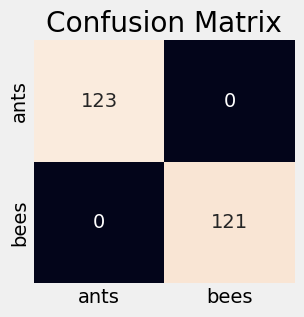

In [37]:
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cbar=False)
plt.title("Confusion Matrix")
plt.show()